A notebook for configuring the cameras of each channel of the Kameda Lab Orochi Simulator.

# Overview

This notebook guides the user through connection to each of the channels of the OROCHI simulator, and gives prompts for recording the channel number, the centre-wavelength, full-width-at-half-maximum, f-number, and region-of-interest of sample area, associated with each channel camera system, indexed by serial number.

First we write a look-up-table of camera properties, and then we will attach the serial number of the associated camera to the camera properties.

The steps are:
1. Get list of serial numbers of devices connected.
For each device:
2. Begin live feed
3. Establish position of camera in rig (manual)
4. Prompt user to enter camera number
5. Assign serial number to camera number
6. Write look-up-table of properties of camera number, and add serial number
7. Automatically set region of interest
8. Check region of interest
9. Write region of interest to properties

# Camera Properties

There are 8 OROCHI channels, labelled 1 - 8, with band 8 as the monochromatic band.

| Band | CWL (nm) | FWHM (nm) | f# |
|------|----------|-----------|----|
| 1    | 400      | 50        |6.4 |
| 2    | 475      | 25        |6.4 |
| 3    | 550      | 25        |6.4 |
| 4    | 650      | 50        |6.4 |
| 5    | 725      | 50        |6.4 |
| 6    | 850      | 50        |6.2 |
| 7    | 950      | 50        |5.8 |
| 8    | 550      | 250       |6.4 |

These f-numbers are for the equivalent OROCHI FM channels, from the Kameda et al 2021 paper. I need to verify that the same are used for the simulator.
Note that these values are not currently used in the processing, but recorded in the metadata for future reference.

We store this information in a dictionary of dictionaries, labelled by band name, but we will replace these labels with the device name of each camera.

In [1]:
cameras = {
        'Band1':
             {'number': 1,
              'serial': None,
              'fnumber': 6.4,
              'flength': None,
              'cwl': 400.0,
              'fwhm': 50.0,
              'width': 1920,
              'height': 1200,
              'roi': {
                     'x': 0,
                     'y': 0,
                     'w': 1920,
                     'h': 1200}
              },
        'Band2':
             {'number': 2,
              'serial': None,
              'fnumber': 6.4,
              'flength': None,
              'cwl': 475.0,
              'fwhm': 25.0,
              'width': 1920,
              'height': 1200,
              'roi': {
                     'x': 0,
                     'y': 0,
                     'w': 1920,
                     'h': 1200}
              },
        'Band3':
             {'number': 3,
              'serial': None,
              'fnumber': 6.4,
              'flength': None,
              'cwl': 550.0,
              'fwhm': 25.0,
              'width': 1920,
              'height': 1200,
              'roi': {
                     'x': 0,
                     'y': 0,
                     'w': 1920,
                     'h': 1200}
              },
        'Band4':
             {'number': 4,
              'serial': None,
              'fnumber': 6.4,
              'flength': None,
              'cwl': 650.0,
              'fwhm': 50.0,
              'width': 1920,
              'height': 1200,
              'roi': {
                     'x': 0,
                     'y': 0,
                     'w': 1920,
                     'h': 1200}
              },    
        'Band5':
             {'number': 5,
              'serial': None,
              'fnumber': 6.4,
              'flength': None,
              'cwl': 725.0,
              'fwhm': 50.0,
              'width': 1920,
              'height': 1200,
              'roi': {
                     'x': 0,
                     'y': 0,
                     'w': 1920,
                     'h': 1200}
              },  
        'Band6':
             {'number': 6,
              'serial': None,
              'fnumber': 6.2,
              'flength': None,
              'cwl': 850.0,
              'fwhm': 50.0,
              'width': 1920,
              'height': 1200,
              'roi': {
                     'x': 0,
                     'y': 0,
                     'w': 1920,
                     'h': 1200}
              },  
        'Band7':
             {'number': 7,
              'serial': None,
              'fnumber': 5.8,
              'flength': None,
              'cwl': 950.0,
              'fwhm': 50.0,
              'width': 1920,
              'height': 1200,
              'roi': {
                     'x': 0,
                     'y': 0,
                     'w': 1920,
                     'h': 1200}
              },  
        'Band8':
             {'number': 8,
              'serial': None,
              'fnumber': 6.4,
              'flength': None,
              'cwl': 550.0,
              'fwhm': 250.0,
              'width': 1920,
              'height': 1200,
              'roi': {
                     'x': 0,
                     'y': 0,
                     'w': 1920,
                     'h': 1200}
              },  
       }

# Getting the list of available cameras

Here we connect to the available cameras, and get a list of their names.

In [2]:
import tisgrabber as tis
from pathlib import Path
import ctypes
import numpy as np
import tifffile as tiff
import matplotlib.pyplot as plt
import pandas as pd

# get the location of the tisgrabber_x64.dll file
tis_dir = Path(tis.__file__).resolve().parents[0]
tis_dll = str(Path(tis_dir, 'tisgrabber_x64.dll'))

# Load/Initiate the tisgrabber library
ic = ctypes.cdll.LoadLibrary(tis_dll)
tis.declareFunctions(ic)
ic.IC_InitLibrary(0)

1

In [4]:
class CallbackUserdata(ctypes.Structure):
    """ Example for user data passed to the callback function. 
    """
    def __init__(self, ):
        self.unsused = ""
        self.devicename = ""
        self.connected = False


def frameReadyCallback(hGrabber, pBuffer, framenumber, pData):
    # Maybe do something here.
    return


def deviceLostCallback(hGrabber, userdata):
    """ This a device lost callback function. Called, if the camera disconnects. 
    This function runs in the Grabber thread, not in the main thread.
    :param: hGrabber: This is the real pointer to the grabber object. Do not use.
    :param: pData : Pointer to additional user data structure
    """
    userdata.connected = False
    print("Device {} lost".format(userdata.devicename))

Now we will get the list of cameras available:

In [7]:
connected_cameras = []
devicecount = ic.IC_GetDeviceCount()
for i in range(0, devicecount):
    uniquename = tis.D(ic.IC_GetUniqueNamefromList(i))
    connected_cameras.append(uniquename)

Now for each of these cameras in turn, we will create a tisgrabber.

In [11]:
grabbers = {}
for camera in connected_cameras:
    cam_name = camera
    grabber = ic.IC_CreateGrabber()
    ic.IC_OpenDevByUniqueName(grabber, tis.T(cam_name))

    frameReadyCallbackfunc = ic.FRAMEREADYCALLBACK(frameReadyCallback)
    userdata = CallbackUserdata()
    devicelostcallbackfunc = ic.DEVICELOSTCALLBACK(deviceLostCallback)

    userdata.devicename = cam_name
    userdata.connected = True

    ic.IC_SetCallbacks(grabber,
                    frameReadyCallbackfunc, None,
                    devicelostcallbackfunc, userdata)

    # check the device is connected
    if ic.IC_IsDevValid(grabber):
        print(f'Device {cam_name} succesfully connected.')
    else:
        err_string = f'Camera {cam_name} did not connect - check connection and try again'
        ic.IC_MsgBox( tis.T(err_string),tis.T("Connection Error"))
    
    grabbers[cam_name] = grabber

Device DMK 33GX249 10910265 succesfully connected.


# Finding the Band Number for each Camera

Now we will connect to each of these cameras in turn, and begin a live video.

To find the camera number, wave in front of each channel of the OROCHI simulator in turn, and note the band number of the camera you see your hand in.

Then enter the band number after the prompt.

In [22]:
labelled_cameras = {}
for cam_name in connected_cameras:
    grabber = grabbers[cam_name]
    ic.IC_StartLive(grabber,1)
    ic.IC_MsgBox(tis.T('Find the band number by waving in front of each camera'), tis.T('Camera Configuration'))
    ic.IC_StopLive(grabber,1)
    band_number = input(prompt='Enter band number e.g. "3"')
    band_label = f'Band{band_number}'
    cameras[band_label]['serial'] = cam_name
    labelled_cameras[cam_name] = cameras[band_label]

Now we have a dictionary labelled by camera serial number.

In [23]:
print(labelled_cameras)

{'DMK 33GX249 10910265': {'number': 6, 'serial': 'DMK 33GX249 10910265', 'fnumber': 6.2, 'flength': None, 'cwl': 850.0, 'fwhm': 50.0, 'width': 1920, 'height': 1200, 'roi': {'x': 0, 'y': 0, 'w': 1920, 'h': 1200}}}


# Setting Region of Interest

The sample typically occupies only a small portion of the image, so it is useful to record this region of interest for future use.

We can do this by simply finding the brightest pixel after blurring, and centering a 128 x 128 window around this.

In [39]:
def set_defaults(grabber, exposure=1.0/100, auto_exposure=1, black_level=26):
    black_level = black_level*2**4
    set_property('Brightness', 'Value', black_level, 'Range', grabber) # brightness is Black Level in DN for the 12-bit range of the detector. Default is to 10% of detector range, for linearity
    set_property('Contrast', 'Value', 0, 'Range', grabber)
    set_property('Sharpness', 'Value', 0, 'Range', grabber)    
    set_property('Gamma', 'Value', 100, 'Range', grabber)
    set_property('Gain', 'Value', 0.0, 'AbsoluteValue', grabber)
    set_property('Gain', 'Auto', 0, 'Switch', grabber)
    set_property('Exposure', 'Value', exposure, 'AbsoluteValue', grabber)
    set_property('Exposure', 'Auto', auto_exposure, 'Switch', grabber)
    set_property('Exposure', 'Auto Reference', 80, 'Range', grabber)
    set_property('Exposure', 'Auto Max Value', 2.0, 'AbsoluteValue', grabber)
    set_property('Exposure', 'Auto Max Auto', 0, 'Switch', grabber)
    set_property('Trigger', 'Enable', 0, 'Switch', grabber)
    set_property('Denoise', 'Value', 0, 'Range', grabber)
    set_property('Flip Horizontal', 'Enable', 0, 'Switch', grabber)
    set_property('Flip Vertical', 'Enable', 0, 'Switch', grabber)
    set_property('Highlight Reduction', 'Enable', 0, 'Switch', grabber)
    set_property('Tone Mapping', 'Enable', 0, 'Switch', grabber)
    set_property('Strobe', 'Enable', 0, 'Switch', grabber)
    set_property('Auto Functions ROI', 'Enabled', 0, 'Switch', grabber)

In [40]:
def set_property(property: str, element: str, value, interface: str, hGrabber):
    
    if interface == 'Range':
        set_property_func = ic.IC_SetPropertyValue
        value = ctypes.c_int(value)
    elif interface == 'AbsoluteValue':
        set_property_func = ic.IC_SetPropertyAbsoluteValue
        value = ctypes.c_float(value)
    elif interface == 'AbsoluteValueRange':
        set_property_func = ic.IC_SetPropertyAbsoluteValueRange
        value = ctypes.c_float(value)
    elif interface == 'Switch':
        set_property_func = ic.IC_SetPropertySwitch
        value = ctypes.c_int(value)
    elif interface == 'MapStrings':
        set_property_func = ic.IC_SetPropertyMapStrings
        value = ctypes.c_char(value)
    elif interface == 'Button':
        set_property_func = ic.IC_SetPropertyOnePush
        value = ctypes.c_int(value)

    ret = set_property_func(
            hGrabber, 
            property.encode("utf-8"),
            element.encode("utf-8"), 
            value)
    if ret == 1:
        print(f'{property} {element} set to {value.value}')
    elif ret == -2:
        raise ValueError('No video capture device opened')
    elif ret == -4:
        raise ValueError(f'{property} is not available')
    elif ret == -5:
        raise ValueError(f'{property} item {element} is not available')
    elif ret == -6:
        raise ValueError(f'{property} {element} has no interface')

In [18]:
def get_image_info(grabber):
    width = ctypes.c_long()
    height = ctypes.c_long()
    bits = ctypes.c_long()
    col_fmt = ctypes.c_int()

    ic.IC_GetImageDescription(grabber, width, height,
                            bits, col_fmt)


    bpp = int(bits.value / 8.0)
    buffer_size = width.value * height.value * bits.value

    return width.value, height.value, buffer_size, bpp

In [74]:
def image_capture(grabber, camera=None, roi=False):

    ic.IC_StartLive(grabber,1)
    ic.IC_SnapImage(grabber, 2000) == tis.IC_SUCCESS
    ic.IC_StopLive(grabber,1)

    width, height, buffer_size, bpp = get_image_info(grabber)

    # Get the image data
    imagePtr = ic.IC_GetImagePtr(grabber)

    imagedata = ctypes.cast(imagePtr,
                            ctypes.POINTER(ctypes.c_ubyte *
                                        buffer_size))

    # Create the numpy array
    image = np.ndarray(buffer=imagedata.contents,
                    dtype=np.uint8,
                    shape=(height,
                            width,
                            bpp))

    if roi:
        x = camera['roi']['x']
        y = camera['roi']['y']
        w = camera['roi']['w']
        h = camera['roi']['h']
        image = image[x:x+w,y:y+h,0]
    else:
        image = image[:,:,0]
    return image

In [75]:
def show_image(img_arr, title):
    plt.imshow(img_arr, origin='lower')
    plt.title(title)
    plt.colorbar()

C:\Users\kameken\AppData\Local\Temp\ipykernel_440\2684724230.py:1: DeprecationWarning: Please use `gaussian_filter` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  from scipy.ndimage.filters import gaussian_filter


Brightness Value set to 416
Contrast Value set to 0
Sharpness Value set to 0
Gamma Value set to 100
Gain Value set to 0.0
Gain Auto set to 0
Exposure Value set to 0.009999999776482582
Exposure Auto set to 1
Exposure Auto Reference set to 80
Exposure Auto Max Value set to 2.0
Exposure Auto Max Auto set to 0
Trigger Enable set to 0
Denoise Value set to 0
Flip Horizontal Enable set to 0
Flip Vertical Enable set to 0
Highlight Reduction Enable set to 0
Tone Mapping Enable set to 0
Strobe Enable set to 0
Auto Functions ROI Enabled set to 0
x: 480
y: 960


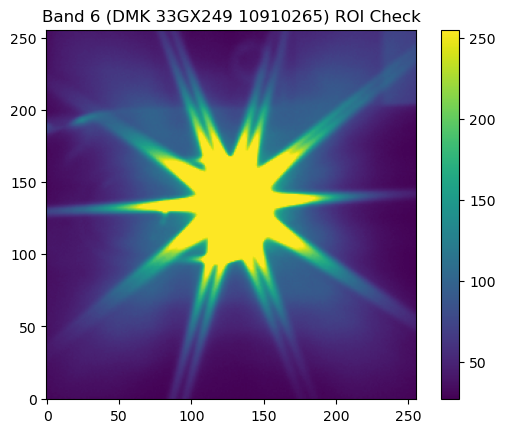

In [84]:
from scipy.ndimage.filters import gaussian_filter

size = 256 # size of ROI
for cam_name in labelled_cameras:
    grabber = grabbers[cam_name]
    set_defaults(grabber)
    img = image_capture(grabber)
    blurred = gaussian_filter(img, sigma=15)
    cntr = np.unravel_index(np.argmax(blurred, axis=None), blurred.shape)
    xlim = cntr[0]-int(size/2)
    ylim = cntr[1]-int(size/2)
    print(f'x: {xlim}')
    print(f'y: {ylim}')
    labelled_cameras[cam_name]['roi']['x'] = xlim
    labelled_cameras[cam_name]['roi']['y'] = ylim
    labelled_cameras[cam_name]['roi']['w'] = size
    labelled_cameras[cam_name]['roi']['h'] = size
    cam_num = labelled_cameras[cam_name]['number']
    title = f'Band {cam_num} ({cam_name}) ROI Check'
    show_image(img, title)


Now we check that the ROIs are satisfactory:

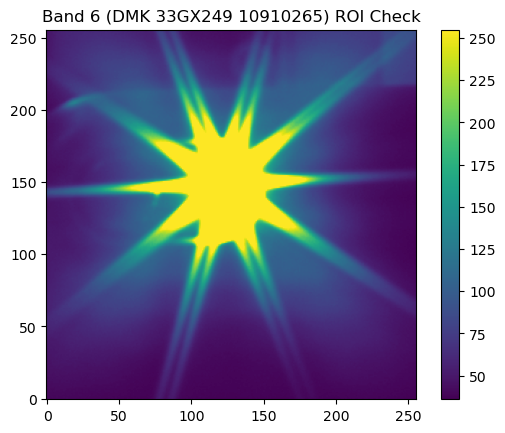

In [85]:
for cam_name in labelled_cameras:
    grabber = grabbers[cam_name]
    img = image_capture(grabber, camera=labelled_cameras[cam_name], roi=True)
    cam_num = labelled_cameras[cam_name]['number']
    title = f'Band {cam_num} ({cam_name}) ROI Check'
    show_image(img, title)